In [1]:
#| echo: false
#| include: false


#Load Package
# ================
# Basic Utilities
# ================
import os
import pandas as pd
from pathlib import Path
import numpy as np

# ================
# Geospatial Data
# ================
import geopandas as gpd
import shapely
from shapely.geometry import Point
from shapely.ops import unary_union

# ================
# Raster Handling
# ================
import rasterio
from rasterio.plot import show
from rasterio.mask import mask 
from rasterio import features
from rasterio.sample import sample_gen

# ================
# Visualization
# ================
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import contextily as ctx

# ================
# Machine Learning
# ================
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

# ================
# Spatial Analysis Utils
# ================
from scipy.ndimage import distance_transform_edt


data_dir = Path("data")
os.listdir(data_dir)


['.ipynb_checkpoints',
 'difference_map.tif',
 'dist_road.tif',
 'dist_village.tif',
 'dist_water.tif',
 'EFCOM_approx.cpg',
 'EFCOM_approx.dbf',
 'EFCOM_approx.prj',
 'EFCOM_approx.shp',
 'EFCOM_approx.shx',
 'gadm41_THA_0.cpg',
 'gadm41_THA_0.dbf',
 'gadm41_THA_0.prj',
 'gadm41_THA_0.shp',
 'gadm41_THA_0.shx',
 'LandCover_EFCOM_to_NDVI.tif',
 'major_roads.geojson',
 'NDVI_EFCOM_32647.tif',
 'NDVI_EFCOM_4326.tif',
 'NDVI_Thailand_2024_fixed.tif',
 'occurrence.geojson',
 'studyregion.geojson',
 'suitability_human.tif',
 'suitability_natural.tif',
 'village_polygon.geojson',
 'water_efcom.geojson',
 'WorldCover_EFCOM_2021.tif']

In [2]:
#| echo: false
#| include: false


#Check CRS

study_region_path = Path(data_dir) / "studyregion.geojson"
if study_region_path.exists():
    region = gpd.read_file(study_region_path)
else:
    region = gpd.read_file(Path(data_dir) / "EFCOM_approx.shp")

print("Study region CRS:", region.crs)

roads = gpd.read_file(Path(data_dir) / "major_roads.geojson")
villages = gpd.read_file(Path(data_dir) / "village_polygon.geojson")
water = gpd.read_file(Path(data_dir) / "water_efcom.geojson")
occ = gpd.read_file(Path(data_dir) / "occurrence.geojson")

print("Roads CRS:", roads.crs)
print("Villages CRS:", villages.crs)
print("Water CRS:", water.crs)
print("Occurrence CRS:", occ.crs)


Study region CRS: EPSG:4326


C:\Users\m1870\.conda\envs\musa\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Several features with id = 25830291 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(
C:\Users\m1870\.conda\envs\musa\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Several features with id = 477127100 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(


Roads CRS: EPSG:4326
Villages CRS: EPSG:4326
Water CRS: EPSG:4326
Occurrence CRS: EPSG:4326


In [3]:
#| echo: false
#| include: false

#Trim Elephant Data To Study Region

region_union = region.unary_union
occ_in_region = occ[occ.within(region_union)].copy()

print("All elephant points:", len(occ))
print("Elephant points inside region:", len(occ_in_region))


All elephant points: 577
Elephant points inside region: 260


C:\Users\m1870\AppData\Local\Temp\ipykernel_27056\857401672.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  region_union = region.unary_union


In [4]:
#| echo: false
#| include: false


ndvi_path = Path(data_dir) / "NDVI_Thailand_2024_fixed.tif"
ndvi_src = rasterio.open(ndvi_path)

print("NDVI CRS:", ndvi_src.crs)
print("NDVI bounds:", ndvi_src.bounds)
print("NDVI resolution:", ndvi_src.transform.a, ndvi_src.transform.e)

ndvi = ndvi_src.read(1)
ndvi = ndvi.astype("float32")
ndvi[ndvi <= -9999] = np.nan  

print("NDVI min/max (ignoring NaN):", np.nanmin(ndvi), np.nanmax(ndvi))


NDVI CRS: PROJCS["WGS 84 / UTM zone 47N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",99],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
NDVI bounds: BoundingBox(left=704880.0, bottom=1343880.0, right=878400.0, top=1638090.0)
NDVI resolution: 30.0 -30.0
NDVI min/max (ignoring NaN): -0.38841534 0.71352226


In [5]:
#| echo: false
#| include: false


region_ndvi = region.to_crs(ndvi_src.crs)
geoms = [geom for geom in region_ndvi.geometry]

ndvi_clip, ndvi_clip_transform = mask(ndvi_src, geoms, crop=True)
ndvi_clip = ndvi_clip[0] 

print("Clipped NDVI shape:", ndvi_clip.shape)
print("Clipped NDVI min/max:", ndvi_clip.min(), ndvi_clip.max())


Clipped NDVI shape: (8924, 5435)
Clipped NDVI min/max: -0.36105967 0.71352226


In [6]:
#| echo: false
#| include: false

# 先确保大象点的 CRS 和 NDVI 一致（NDVI 是 4326）
occ_ndvi = occ_in_region.to_crs(ndvi_src.crs)

# 提取点坐标
coords = [(x,y) for x, y in zip(occ_ndvi.geometry.x, occ_ndvi.geometry.y)]

# 在 NDVI 栅格上采样
ndvi_at_elephants = list(ndvi_src.sample(coords))
ndvi_at_elephants = np.array(ndvi_at_elephants).flatten().astype("float32")

# 去掉可能的 NaN（落在 NoData 区域的点）
ndvi_at_elephants = ndvi_at_elephants[~np.isnan(ndvi_at_elephants)]

print("Elephant NDVI count:", len(ndvi_at_elephants))
print("Elephant NDVI min/max:", ndvi_at_elephants.min(), ndvi_at_elephants.max())
print("Elephant NDVI mean:", ndvi_at_elephants.mean())


Elephant NDVI count: 260
Elephant NDVI min/max: 0.02474089 0.59356636
Elephant NDVI mean: 0.4537316


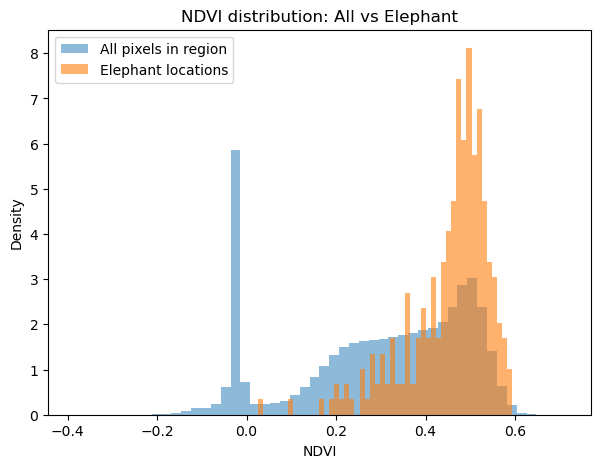

In [7]:
#| echo: false
#| include: false


# 全区域 NDVI 展平 & 去 NaN
ndvi_all = ndvi.flatten()
ndvi_all = ndvi_all[~np.isnan(ndvi_all)]

plt.figure(figsize=(7,5))

plt.hist(ndvi_all, bins=50, alpha=0.5, density=True, label="All pixels in region")
plt.hist(ndvi_at_elephants, bins=50, alpha=0.6, density=True, label="Elephant locations")

plt.xlabel("NDVI")
plt.ylabel("Density")
plt.title("NDVI distribution: All vs Elephant")
plt.legend()
plt.show()



In [8]:
#| echo: false
#| include: false

lc_path = data_dir / "WorldCover_EFCOM_2021.tif"
lc_src = rasterio.open(lc_path)

print("LandCover CRS:", lc_src.crs)
print("LandCover bounds:", lc_src.bounds)
print("LandCover resolution:", lc_src.transform.a, lc_src.transform.e)

lc = lc_src.read(1)
print("Unique landcover classes in full raster:", np.unique(lc))


LandCover CRS: GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
LandCover bounds: BoundingBox(left=100.99983318176811, bottom=12.29973287016449, right=102.60009202889863, top=14.700121140860263)
LandCover resolution: 0.00026949458523585647 -0.00026949458523585647
Unique landcover classes in full raster: [ 0 10 20 30 40 50 60 80 90 95]


In [9]:
#| echo: false
#| include: false


region_lc = region.to_crs(lc_src.crs)
geoms_lc = [geom for geom in region_lc.geometry]

lc_clip, lc_clip_transform = rasterio.mask.mask(lc_src, geoms_lc, crop=True)
lc_clip = lc_clip[0]

print("Clipped LC shape:", lc_clip.shape)
print("Unique classes in clipped LC:", np.unique(lc_clip))


Clipped LC shape: (8907, 5938)
Unique classes in clipped LC: [ 0 10 20 30 40 50 60 80 90 95]


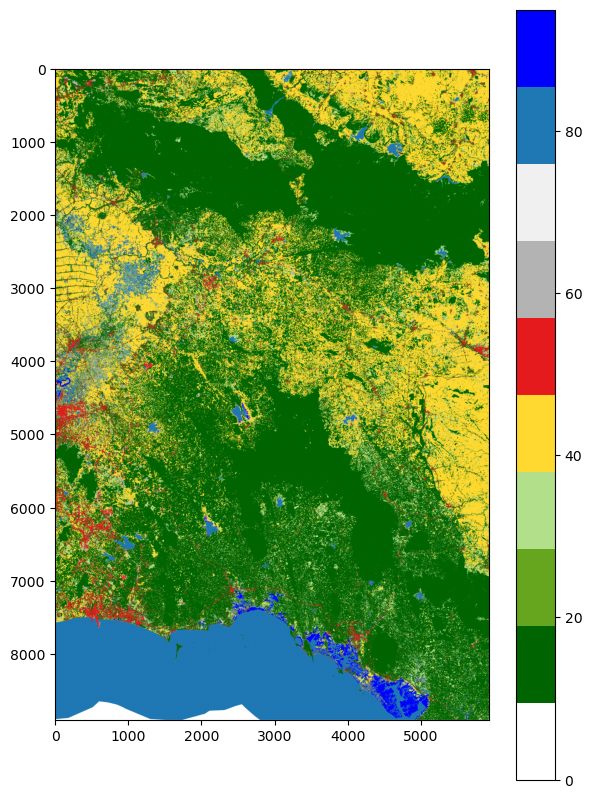

In [10]:
#| echo: false
#| include: false

class_colors = [
    "#ffffff",  # 0  No data
    "#006400",  # 10 Tree - dark green
    "#66a61e",  # 20 Shrub - olive green
    "#b2df8a",  # 30 Grass - light green
    "#ffd92f",  # 40 Cropland - light yellow
    "#e41a1c",  # 50 Built-up - red
    "#b3b3b3",  # 60 Bare - grey
    "#f0f0f0",  # 80 Snow/Ice - white
    "#1f78b4",  # 90 Wetlands - teal blue
    "#0000ff",  # 95 Water - blue
]


cmap = ListedColormap(class_colors)

plt.figure(figsize=(7, 10))
plt.imshow(lc_clip, cmap=cmap)
plt.colorbar()
plt.show()


In [11]:
#| echo: false
#| include: false

class_meaning = {
    0:  "No data",
    10: "Tree cover",
    20: "Shrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Built-up",
    60: "Bare/Sparse vegetation",
    80: "Snow/Ice",
    90: "Wetlands",
    95: "Water"
}

unique, counts = np.unique(lc_clip, return_counts=True)

df_lc = pd.DataFrame({
    "ClassValue": unique,
    "Meaning": [class_meaning.get(v, "Unknown") for v in unique],
    "Count": counts
})

df_lc["Percentage"] = (df_lc["Count"] / df_lc["Count"].sum() * 100).round(2)

df_lc


ClassValue                 Meaning     Count  Percentage
0           0                 No data    292666        0.55
1          10              Tree cover  28505457       53.90
2          20               Shrubland      3019        0.01
3          30               Grassland   4133549        7.82
4          40                Cropland  11810797       22.33
5          50                Built-up   1499059        2.83
6          60  Bare/Sparse vegetation    292243        0.55
7          80                Snow/Ice   5949448       11.25
8          90                Wetlands     91315        0.17
9          95                   Water    312213        0.59

In [12]:
#| echo: false
#| include: false

# 输入：occurrence_in_region（象点）
ele_df = occ_in_region.copy()

coords = [(x,y) for x,y in zip(ele_df.geometry.x, ele_df.geometry.y)]

with rasterio.open(lc_path) as src:
    ele_df["landcover"] = [v[0] for v in src.sample(coords)]

ele_df.head()


gbifID accessRights bibliographicCitation language       license  \
1   5892584119         None                  None     None  CC_BY_NC_4_0   
4   5889647550         None                  None     None  CC_BY_NC_4_0   
6   5889402805         None                  None     None  CC_BY_NC_4_0   
10  5838232009         None                  None     None  CC_BY_NC_4_0   
12  5838086501         None                  None     None  CC_BY_NC_4_0   

                    modified publisher  \
1  2025-11-06 13:07:19+00:00      None   
4  2025-10-24 06:51:04+00:00      None   
6  2025-11-04 20:25:29+00:00      None   
10 2025-10-03 20:16:07+00:00      None   
12 2025-09-27 03:09:24+00:00      None   

                                           references          rightsHolder  \
1   https://www.inaturalist.org/observations/32514...           CaracalShan   
4   https://www.inaturalist.org/observations/32270...              balayska   
6   https://www.inaturalist.org/observations/32473...           Toby Austin   
10  https://www.inaturalist.org/observations/31770...  Sila Viriyautsahakul   
12  https://www.inaturalist.org/observations/31422...         julien CLAUDE   

    type  ... level0Name level1Gid         level1Name    level2Gid  \
1   None  ...   Thailand  THA.60_1           Saraburi   THA.60.5_1   
4   None  ...   Thailand  THA.29_1  Nakhon Ratchasima  THA.29.25_1   
6   None  ...   Thailand  THA.29_1  Nakhon Ratchasima  THA.29.25_1   
10  None  ...   Thailand  THA.26_1       Nakhon Nayok   THA.26.2_1   
12  None  ...   Thailand  THA.29_1  Nakhon Ratchasima  THA.29.25_1   

            level2Name      level3Gid  level3Name iucnRedListCategory  \
1             Muak Lek   THA.60.5.3_1  Mittraphap                  EN   
4            Pak Chong  THA.29.25.5_1       Mu Si                  EN   
6            Pak Chong  THA.29.25.1_1   Chanthuek                  EN   
10  Muang Nakhon Nayok   THA.26.2.1_1        None                  EN   
12           Pak Chong  THA.29.25.4_1  Klang Dong                  EN   

                      geometry landcover  
1   POINT (101.20073 14.44923)        10  
4   POINT (101.45096 14.51415)        30  
6   POINT (101.34412 14.58563)        10  
10  POINT (101.25046 14.45802)        10  
12   POINT (101.2909 14.59323)        10  

[5 rows x 228 columns]

In [13]:
#| echo: false
#| include: false

class_colors = {
    0:  "#ffffff",  # No data
    10: "#006400",  # Tree
    20: "#66a61e",  # Shrub
    30: "#b2df8a",  # Grass
    40: "#ffd92f",  # Cropland
    50: "#e41a1c",  # Built-up
    60: "#b3b3b3",  # Bare
    80: "#f0f0f0",  # Snow/Ice
    90: "#1f78b4",  # Wetlands
    95: "#0000ff",  # Water
}


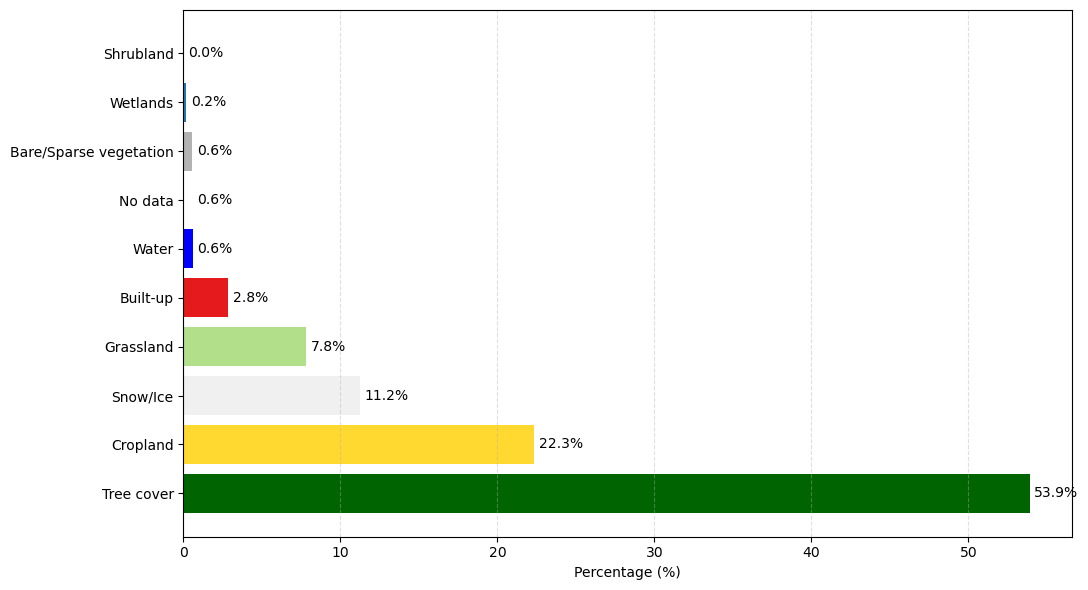

In [14]:
#| echo: false
#| include: false

# Sort dataframe by % (largest to smallest)
df_plot = df_lc.sort_values("Percentage", ascending=False).copy()

# Map colors
df_plot["Color"] = df_plot["ClassValue"].map(class_colors)

# Plot
plt.figure(figsize=(11, 6))
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.barh(df_plot["Meaning"], df_plot["Percentage"], color=df_plot["Color"])
plt.xlabel("Percentage (%)")

# Add % text to bars
for i, v in enumerate(df_plot["Percentage"]):
    plt.text(v + 0.3, i, f"{v:.1f}%", va="center")

plt.tight_layout()
plt.show()



In [15]:
#| echo: false
#| include: false

efcom = gpd.read_file(
    r"data/studyregion.geojson"
)
efcom = efcom.to_crs(epsg=4326)


# 2. 随机点生成函数
def generate_random_points(polygon, n_points):
    minx, miny, maxx, maxy = polygon.bounds
    points = []
    count = 0
    
    while count < n_points:
        x = np.random.uniform(minx, maxx)
        y = np.random.uniform(miny, maxy)
        p = Point(x, y)
        if polygon.contains(p):
            points.append(p)
            count += 1
    return points

# 3. 生成 4000 个背景点
background_pts = generate_random_points(efcom.geometry.iloc[0], 4000)

background_gdf = gpd.GeoDataFrame(geometry=background_pts, crs="EPSG:4326")
background_gdf.to_file("background_points.geojson", driver="GeoJSON")


In [16]:
#| echo: false
#| include: false

ndvi_src = rasterio.open("data/NDVI_EFCOM_4326.tif")
lc_src   = rasterio.open("data/WorldCover_EFCOM_2021.tif")

def extract_raster_values(gdf, raster_src, colname):
    coords = [(x,y) for x,y in zip(gdf.geometry.x, gdf.geometry.y)]
    values = [val[0] for val in raster_src.sample(coords)]
    gdf[colname] = values
    return gdf

# Presence points
occ = extract_raster_values(occ_in_region, ndvi_src, "NDVI")
occ = extract_raster_values(occ, lc_src, "LC")

# Background points
bg  = extract_raster_values(background_gdf, ndvi_src, "NDVI")
bg  = extract_raster_values(bg, lc_src, "LC")


In [17]:
#| echo: false
#| include: false

def compute_distance(gdf, features_gdf, colname):
    """给每个点算到某类要素的最短距离"""
    union_geom = unary_union(features_gdf.geometry)
    gdf[colname] = gdf.geometry.apply(lambda x: x.distance(union_geom))
    return gdf

# 1. 先对 presence/background 都做距离特征
occ = compute_distance(occ, water,    "dist_water")
occ = compute_distance(occ, roads,    "dist_road")
occ = compute_distance(occ, villages, "dist_village")

bg  = compute_distance(bg, water,    "dist_water")
bg  = compute_distance(bg, roads,    "dist_road")
bg  = compute_distance(bg, villages, "dist_village")


In [18]:
#| echo: false
#| include: false

# 打标签
occ["presence"] = 1
bg["presence"]  = 0

cols_keep = ["NDVI", "LC", "dist_water", "dist_road", "dist_village", "presence"]

df = pd.concat([occ[cols_keep], bg[cols_keep]], ignore_index=True)

df["LC"] = df["LC"].astype("int32")

# 简单检查一下
print(df.head())
print(df["presence"].value_counts())


       NDVI  LC  dist_water  dist_road  dist_village  presence
0  0.454901  10    0.041045   0.104217      0.023324         1
1  0.261992  30    0.002616   0.132970      0.003885         1
2  0.333858  10    0.021377   0.042900      0.005348         1
3  0.508838  10    0.083699   0.154307      0.059516         1
4  0.525954  10    0.028356   0.028713      0.019645         1
presence
0    4000
1     260
Name: count, dtype: int64


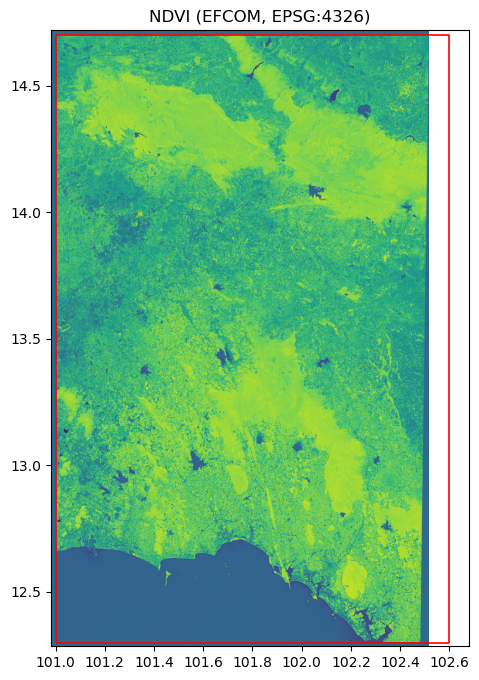

In [19]:
#| echo: false
#| include: false

ndvi_4326_path = data_dir / "NDVI_EFCOM_4326.tif"
ndvi_efcom_src = rasterio.open(ndvi_4326_path)
ndvi_efcom = ndvi_efcom_src.read(1)

fig, ax = plt.subplots(figsize=(6, 8))

show(ndvi_efcom, transform=ndvi_efcom_src.transform, ax=ax, cmap="viridis")
region.boundary.plot(ax=ax, edgecolor="red", linewidth=1.2)

ax.set_title("NDVI (EFCOM, EPSG:4326)")
plt.show()

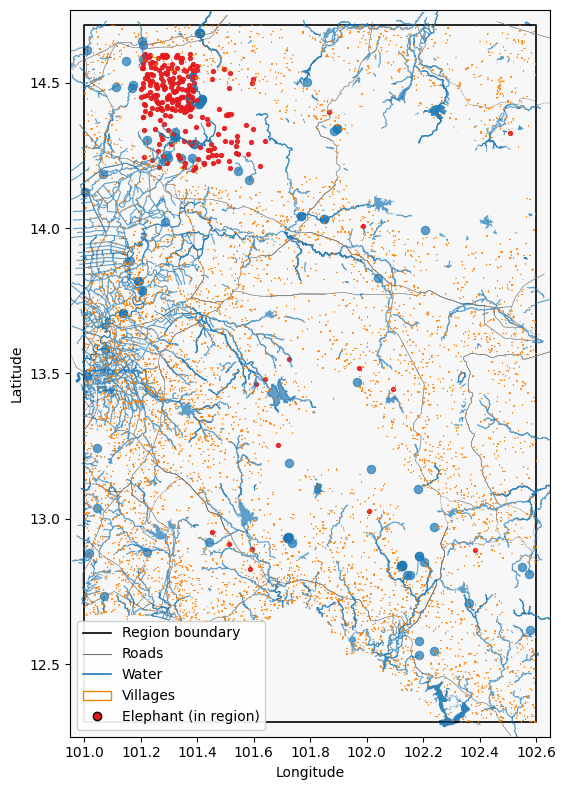

In [20]:
#| echo: false
#| include: false

#Study Region Overview

minx, miny, maxx, maxy = region.total_bounds

fig, ax = plt.subplots(figsize=(6, 8))

# 1. Region Boundary
region.boundary.plot(
    ax=ax,
    edgecolor="black",
    linewidth=1.2
)

# 2. Roads
roads.plot(
    ax=ax,
    linewidth=0.4,
    color="#777777",
    alpha=0.7
)

# 3. Water
water.plot(
    ax=ax,
    linewidth=0.8,
    color="#1f78b4",
    alpha=0.7
)

# 4. Villages Boundary
villages.boundary.plot(
    ax=ax,
    linewidth=0.8,
    edgecolor="#ff7f00",
    alpha=0.8
)

# 5. Occurances
occ_in_region.plot(
    ax=ax,
    markersize=8,
    color="#e31a1c",
    alpha=0.9
)

ax.set_xlim(minx - 0.05, maxx + 0.05)
ax.set_ylim(miny - 0.05, maxy + 0.05)


ax.set_facecolor("#f7f7f7")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

legend_elements = [
    Line2D([0], [0], color="black", lw=1.2, label="Region boundary"),
    Line2D([0], [0], color="#777777", lw=0.8, label="Roads"),
    Line2D([0], [0], color="#1f78b4", lw=1.2, label="Water"),
    Patch(facecolor="none", edgecolor="#ff7f00", label="Villages"),
    Line2D([0], [0], marker="o", color="none",
           markerfacecolor="#e31a1c", markersize=6,
           label="Elephant (in region)")
]

ax.legend(handles=legend_elements, loc="lower left", frameon=True, framealpha=0.9)

plt.tight_layout()
plt.show()

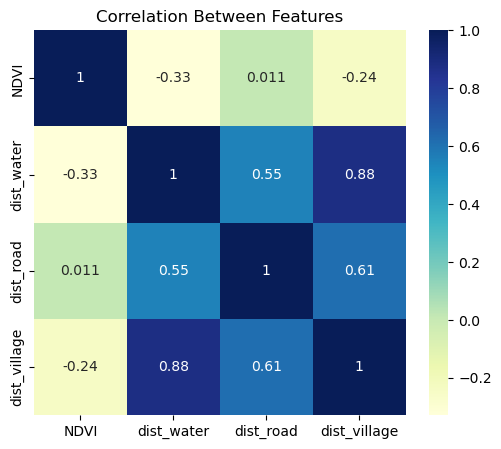

In [21]:
#| echo: false
#| include: false

import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(df[["NDVI","dist_water","dist_road","dist_village"]].corr(),
            annot=True, cmap="YlGnBu")
plt.title("Correlation Between Features")
plt.show()


In [22]:
#| echo: false
#| include: false

# Natural model 
features_natural = ["NDVI", "LC", "dist_water"]

# Human-impact model 
features_human = ["NDVI", "LC", "dist_water", "dist_road", "dist_village"]

X_nat = df[features_natural]
X_hum = df[features_human]
y = df["presence"]

# Split train / test
Xnat_train, Xnat_test, ynat_train, ynat_test = train_test_split(
    X_nat, y, test_size=0.3, random_state=42, stratify=y
)

Xhum_train, Xhum_test, yhum_train, yhum_test = train_test_split(
    X_hum, y, test_size=0.3, random_state=42, stratify=y
)

# Natural model
rf_nat = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_nat.fit(Xnat_train, ynat_train)

y_nat_prob = rf_nat.predict_proba(Xnat_test)[:, 1]
auc_nat = roc_auc_score(ynat_test, y_nat_prob)
print("Natural model AUC:", round(auc_nat, 3))

# Human-impact model
rf_hum = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_hum.fit(Xhum_train, yhum_train)

y_hum_prob = rf_hum.predict_proba(Xhum_test)[:, 1]
auc_hum = roc_auc_score(yhum_test, y_hum_prob)
print("Human-impact model AUC:", round(auc_hum, 3))


Natural model AUC: 0.757
Human-impact model AUC: 0.847


## Result

### Variable Importance

Model results show that NDVI and land cover are the strongest drivers of suitability, with elephants clearly tied to forest quality. In the human-impact model, distance to village becomes similarly important, indicating how settlement edges shape elephant movement, while water and roads add smaller but meaningful contributions.

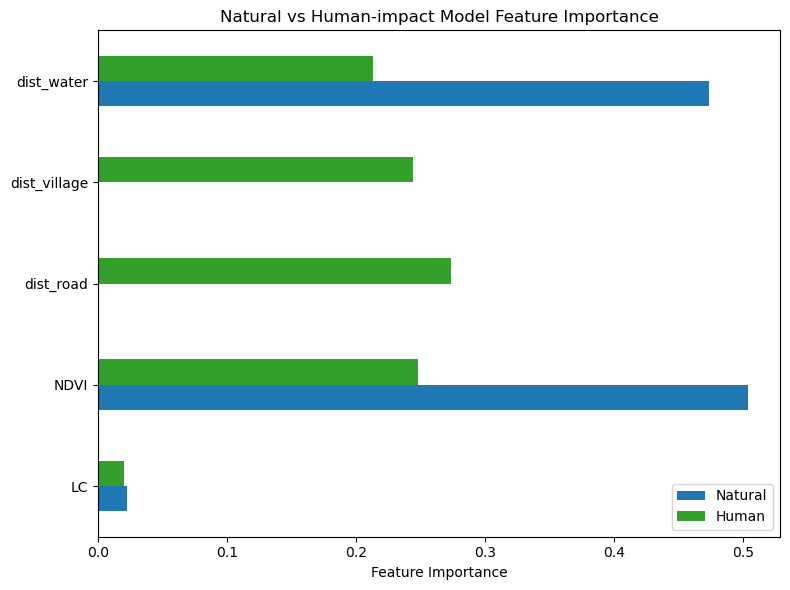

In [23]:
#| code-fold: true
#| fig-cap: "Natural vs Human-impact Model Feature Importance"

# Natural model importance
imp_nat = pd.Series(rf_nat.feature_importances_, index=features_natural)

# Human-impact model importance
imp_hum = pd.Series(rf_hum.feature_importances_, index=features_human)

df_compare = pd.DataFrame({
    "Natural": imp_nat,
    "Human": imp_hum
}).fillna(0)

df_compare.plot(kind="barh", figsize=(8,6), color=["#1f78b4", "#33a02c"])
plt.xlabel("Feature Importance")
plt.title("Natural vs Human-impact Model Feature Importance")
plt.tight_layout()
plt.show()



### ROC curves

Both models perform well, but the human-impact model achieves a higher AUC, showing that human landscape features improve prediction. Its steeper ROC curve indicates a stronger ability to distinguish suitable from unsuitable areas, especially around agricultural and village boundaries.

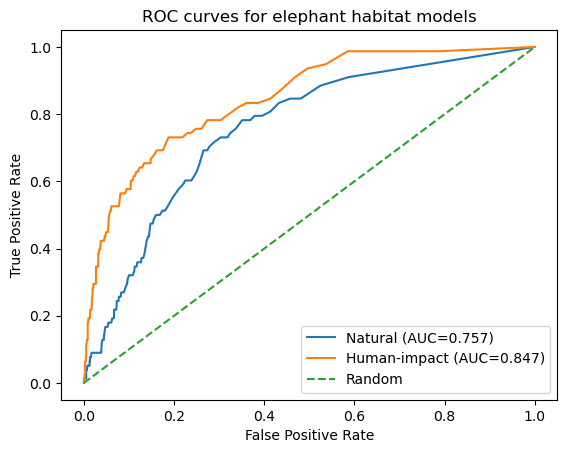

In [24]:
#| code-fold: true
#| fig-cap: "ROC curves for elephant habitat models"

fpr_nat, tpr_nat, _ = roc_curve(ynat_test, y_nat_prob)
fpr_hum, tpr_hum, _ = roc_curve(yhum_test, y_hum_prob)

plt.figure()
plt.plot(fpr_nat, tpr_nat, label=f"Natural (AUC={auc_nat:.3f})")
plt.plot(fpr_hum, tpr_hum, label=f"Human-impact (AUC={auc_hum:.3f})")
plt.plot([0,1],[0,1],'--', label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC curves for elephant habitat models")
plt.show()


### Predictive Maps

The natural-only model highlights large, continuous forest interiors as the strongest habitat for elephants, representing the landscape that would exist if ecological factors alone shaped movement. This smooth pattern shows broad areas of intact forest functioning as cohesive habitat.

**When human-impact variables are added, the suitability surface becomes sharply fragmented.** The prediction clearly shows how roads and settlements break up previously continuous habitat, leaving visible linear barriers across the landscape. **At the same time, certain areas show increased suitability in the human-impact model.** This occurs partly because cropland—especially cornfields—attracts elephants, and partly because **human disturbance compresses elephants into narrower corridors.** This compression elevates predicted occurrence probabilities and increases the contrast between high- and low-suitability zones.

The difference map reinforces this pattern. Human activity has the strongest negative impact in the northern and southern forest belts, where suitability drops substantially once roads, villages, and agricultural edges are accounted for. Most of these areas appear red, indicating habitat that would be highly suitable under natural conditions but is now degraded by fragmentation. Only limited blue patches remain, corresponding to agricultural edges where suitability rises due to food availability and forced movement. Overall, the maps illustrate how human land use simultaneously reduces the extent of natural habitat and intensifies elephant presence in a few high-risk interface zones.

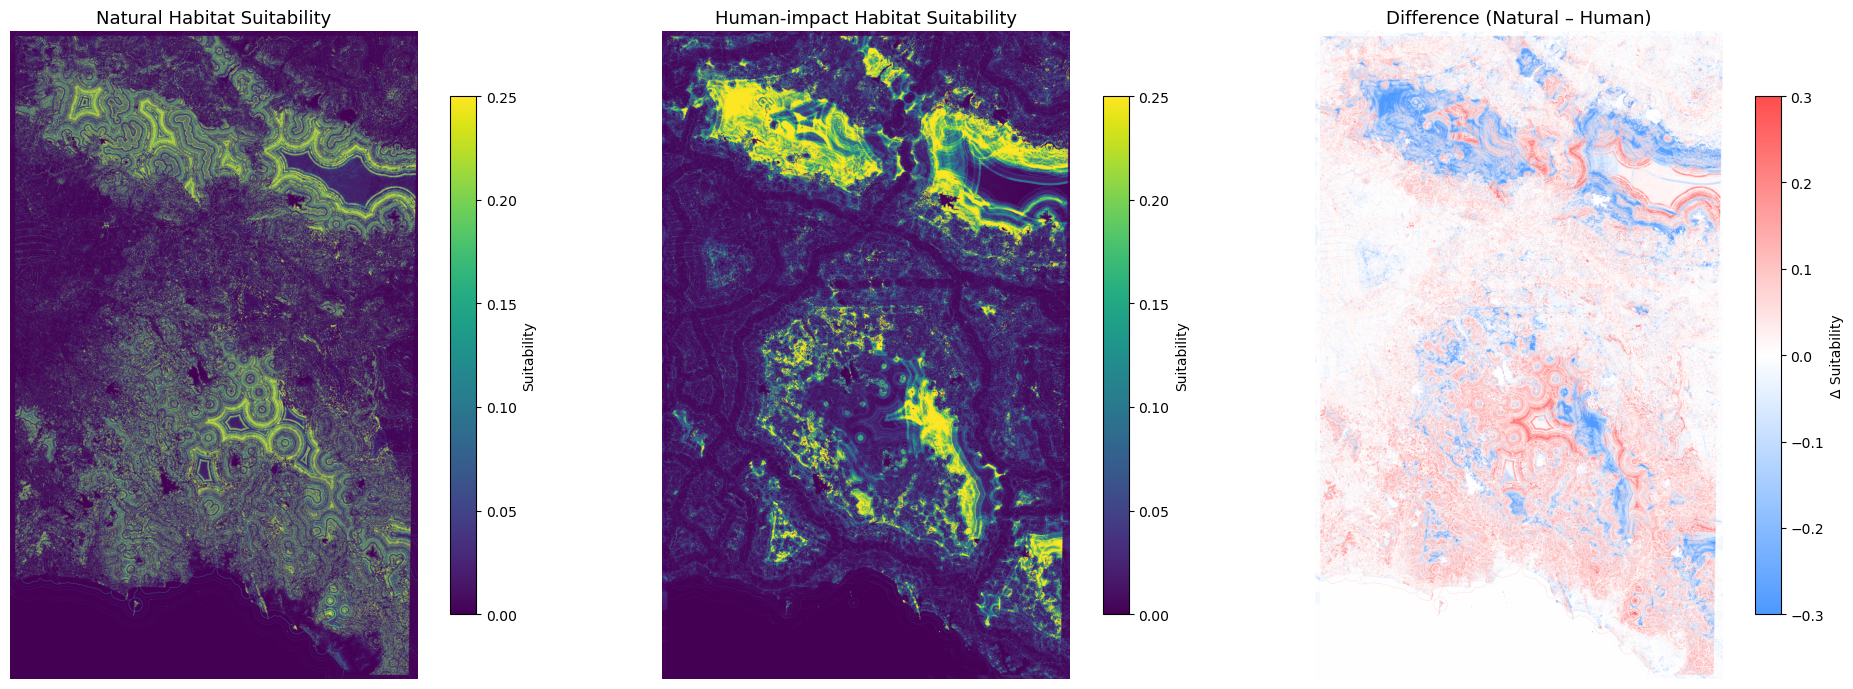

In [25]:
#| code-fold: true
#| fig-cap: "Suitability Maps"

base = r"data/"

nat_path  = base + "suitability_natural.tif"
hum_path  = base + "suitability_human.tif"
diff_path = base + "difference_map.tif"

with rasterio.open(nat_path) as src:
    suit_nat = src.read(1)

with rasterio.open(hum_path) as src:
    suit_hum = src.read(1)

with rasterio.open(diff_path) as src:
    diff = src.read(1)

# Suitability Maps of both models
vmin_suit, vmax_suit = 0, 0.25
fig, axs = plt.subplots(1, 3, figsize=(20, 7))

# 1. Natural suitability
im1 = axs[0].imshow(suit_nat, vmin=0, vmax=0.25, cmap="viridis")
axs[0].set_title("Natural Habitat Suitability", fontsize=13)
axs[0].axis("off")

cbar1 = plt.colorbar(im1, ax=axs[0], shrink=0.8)
cbar1.set_label("Suitability", fontsize=10)


# 2. Human-impact suitability
im2 = axs[1].imshow(suit_hum, vmin=0, vmax=0.25, cmap="viridis")
axs[1].set_title("Human-impact Habitat Suitability", fontsize=13)
axs[1].axis("off")

cbar2 = plt.colorbar(im2, ax=axs[1], shrink=0.8)
cbar2.set_label("Suitability", fontsize=10)


# 3. Difference map
th = 0.02
diff_masked = diff.copy()
diff_masked[np.abs(diff) < th] = 0 

colors = [
    (0.3, 0.6, 1.0),     # blue (human > natural)
    (1.0, 1.0, 1.0),     # white (no significant difference)
    (1.0, 0.3, 0.3)      # red (natural > human)
]
cmap_custom = mcolors.LinearSegmentedColormap.from_list("custom", colors)

im3 = axs[2].imshow(diff_masked, cmap=cmap_custom, vmin=-0.3, vmax=0.3)
axs[2].set_title("Difference (Natural – Human)", fontsize=13)
axs[2].axis("off")

cbar3 = plt.colorbar(im3, ax=axs[2], shrink=0.8)
cbar3.set_label("Δ Suitability", fontsize=10)

plt.tight_layout()
plt.show()
